- Student 1: MANSARD Diane
- Student 2: POTTIER Clément

# Deep learning in finance

## Deep Hedging

Stefano De Marco

The main idea of deep hedging is to parametrize the hedging strategies (at each point in time) via neural networks which can depend on input variables chosen by the user, notably the current asset price (but also possibly the past asset price, etc.).
Eventually, this approach can allow to solve a potentially high dimensional hedging problem with many assets, whose dynamics are described by an arbitrary given model.

## Deep Hedging under log-normal dynamics


Let us recall here the main elements of the problem, in the case of a single asset with price $S$.

+ The goal is delta-hedging of an option $g(S_T)$ with adjustments of the hedging portfolio over a time grid $t_j = j \, \frac T N = j \Delta T$.

+ The hedging portfolio with delta-hedging strategy $\delta_t$ evolves in time as

$$
V_{t_{j+1}}
= V_{t_j} + r (V_{t_j} - \delta_{t_j} S_{t_j}) \Delta t + \delta_{t_j} (S_{t_{j+1}} - S_{t_j}),
\qquad j = 0, \dots, N-1
$$

Therefore, the final portfolio value is

$$
V_T = V_{t_N} = \pi_0 + \sum_{j=0}^{N-1} \bigl( r (V_{t_j} - \delta_{t_j} S_{t_j}) \Delta t + \delta_{t_j} (S_{t_{j+1}} - S_{t_j}) \bigr)
$$

where $V_0 = \pi_0$ is the initial option price (or premium).

+ The model we consider for the underlying asset dynamics has Gaussian log-returns

$$
\log S_{t_{j+1}} = \log S_{t_j} + \mu \Delta t + \sigma \sqrt{\Delta t} \, G_j
$$

where is $(G_j)_{j \ge 1}$ a sequence of independent $\mathcal N (0,1)$ random variables.

We generate a training set of of $N_{\mathrm{train}}$ asset price trajectories $\Bigl( S^i_{t_j} \Bigr)_{0 \le j \le N}^{1 \le i \le N_{\mathrm{train}}}$ according to the model above.

+ _Deep hedging_: the hedging strategy is parameterized by a neural network $h_{\theta_j}$ at each time point $t_j$

$$
\delta_{t_j} = h_{\theta_j} (S_{t_j}), \qquad j = 0, \dots, N-1
$$

and the option premium as well: $\pi_0 = \pi_\theta(S_0)$.

+ The input data $x_i$ correspond to the hedging error over each trajectory (here with $r=0$)

$$
\pi_\theta(S_0) + \sum_{j=0}^{N-1} h_{\theta_j}(S^i_{t_j}) \bigl(S^i_{t_{j+1}} - S^i_{t_j} \bigr) - g\bigl(S^i_T \bigr)
$$

while the output data $y_i$ is simply zero.

+ Loss function: we aim at minimizing

$$
\sum_{i=1}^{N_{\mathrm{train}}}
\Bigl(
\pi_\theta(S_0) + \sum_{j=0}^{N-1} h_{\theta_j}(S^i_{t_j}) \bigl(S^i_{t_{j+1}} - S^i_{t_j} \bigr) - g\bigl(S^i_T \bigr)
\Bigr)^2
$$

over the network parameters $\theta$ and $(\theta_j)_j$.

$\blacktriangleright$ The current notebook is written for zero interest rate $r=0$. This simplifies the formulas we have to implement in the evolution of the hedging portfolio.

Recall that zero interest rate means that we can still construct the self-financing hedging portfolio $V_t = V^0_t + \delta_t \, S_t$ starting from the initial value $\pi_0$ by moving wealth from the cash part $V^0_t$ to the delta hedging part $\delta_t \, S_t$, and vice-versa. Having $r=0$ simply means that the cash part does not provide any interest (nor cost) between time $t_j$ and $t_{j+1}$.

Let us start from this simplified setting. Using a value of $r$ different from zero will be one the To Do's at the end of the notebook.

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.stats as sps

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

from keras.layers import Subtract, Multiply, Lambda, Add, Concatenate

from keras import initializers

import matplotlib.pyplot as plt

In [2]:
N = 100 # number of time steps
S0 = 1 # initial value of the asset (in Euros)

T = 1 # maturity (in years)
strike = 1  # g(S) = (S-K)^+ = call option payoff

sigma = 0.2 # volatility of the Black Scholes trajectories
mu = -0.03 # drift parameter of the log-asset price

r = 0.05 # zero interest rate

$\blacktriangleright$ Theoretical Black-Scholes option price, for reference.

In [3]:
import scipy.stats as sps

# Blackscholes call price
def BS_call_price(S0, strike, T, sigma):
  sigma_sqrt_T = sigma*np.sqrt(T)
  d_1 = np.log(S0/strike) / sigma_sqrt_T + 0.5*sigma_sqrt_T
  d_2 = d_1 - sigma*np.sqrt(T)

  return S0*sps.norm.cdf(d_1) - strike*sps.norm.cdf(d_2)

priceBS = BS_call_price(S0, strike, T, sigma)

print("Price of the Call option in the Black scholes model: %1.4f" %priceBS)

Price of the Call option in the Black scholes model: 0.0797


In [4]:
# Definition of the neural networks for the hedging strategies

m = 1 # dimension of the asset price process
d = 3 # number of layers in the NN for the hedging strategy (including the output layer)
n = 32  # nodes in the first but last layers (the output dimension of the last layer is the desired dimension for the delta)

#################################################################
# The architecture is the same for all networks (that is, for all times t_j)
#################################################################
layers = []

# loop over the time-steps
for j in range(N):
  # loop over the network layers
    for k in range(d):
        if k < d-1:
            nodes = n
            layer = keras.layers.Dense(units = nodes, activation='tanh', trainable=True,
                      kernel_initializer = initializers.RandomNormal(0,1),
                      bias_initializer = 'random_normal',
                      name=str(k)+str(j))
        else:
            ###############################################
            # TO DO: add a densely connected output layer
            # with the appropriate number of nodes
            # and a linear activation function
            ###############################################
            nodes = m
            layer = keras.layers.Dense(units = nodes, activation='sigmoid', trainable=True,
                      kernel_initializer = initializers.RandomNormal(0,1),
                      bias_initializer = 'random_normal',
                      name=str(k)+str(j))
        layers = layers + [layer]

In [5]:
################################
# We construct the training set
################################
grid = [(i/N)*T for i in range(N+1)] # times t_0, t_1, ..., t_N = T
Delta_T = T/N

N_train = 10**5

#######################################################################
# TO DO: generated the asset price log-increments for the training set.
#######################################################################
log_increments = [ mu*Delta_T + sigma*np.random.normal(loc=0, scale=np.sqrt(Delta_T), size=(N_train, m)) for i in range(N) ]  # MODIFY HERE

# The variable xtrain contains:
# the initial asset price S0;
# the initial value of delta hedging part of the portfolio (which is set to zero);
# a grid of points over which the model can output the hedging strategy, for plotting purposes;
# initial guesses for the option premium at time zero (which we simply set to zero);
# the increments of the log price process.

# Concatenation of lists via the operator +
xtrain = ([S0 * np.ones((N_train, m))]  # asset price: same S_0 for all the trajectories
          + [np.zeros((N_train, m))]  # initial delta portion of the portfolio
          + [S0 * np.linspace(0.5, 1.5, N_train).reshape(N_train, m)]  # for plotting purposes: points over which the model can output the hedging strategy. Change this line if you go to higher dimension m
          + [np.zeros((N_train, m))]  # input values for the option premium, for each asset trajectory
          + log_increments)

# ytrain is just zero everywhere
ytrain = np.zeros((N_train, 1))

Let us plot a batch of trajectories coming from the training set:

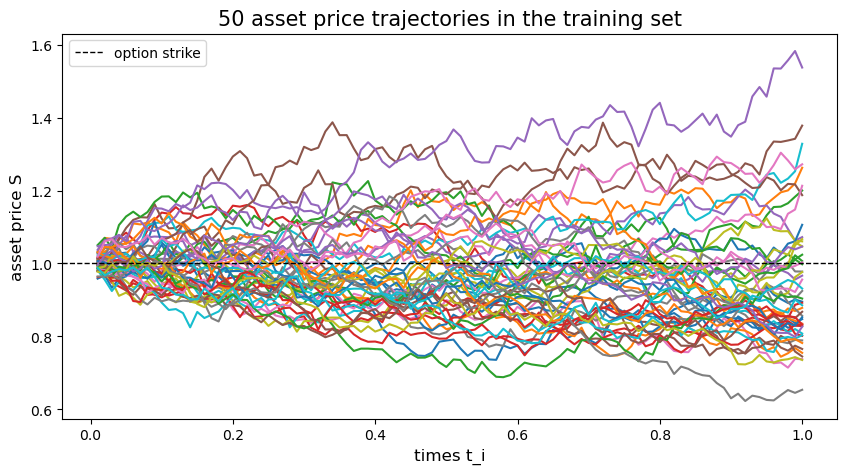

In [6]:
############################################################
## Let us plot the first M trajectories in the training set
#############################################################
# Number of trajectories to plot
M = 50

# We select the log increments to plot
log_increments_to_plot = np.array(log_increments)[:, 0:M, 0] # time step, N_train trajectories, dimension m

# TO DO: construct the asset price trajectories from the log-increments
trajectories_to_plot = S0 * np.exp(np.cumsum(log_increments_to_plot, axis=0)) # MODIFY HERE

plt.figure(figsize=(10,5))
plt.plot(grid[1:], trajectories_to_plot)
plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="option strike")

plt.title("%1.0f asset price trajectories in the training set" %M, fontsize=15)
plt.xlabel("times t_i", fontsize=12)
plt.ylabel("asset price S", fontsize=12)
plt.legend(loc="best")
plt.show()

In [8]:
#########################################
# Construction of the deep hedging model
#########################################
# The inputs will be contained in the training set above
price = keras.Input(shape=(m,)) # initial asset price
hedge = keras.Input(shape=(m,)) # initial value of the delta portion of the portfolio
hedge_eval = keras.Input(shape=(m,)) # for plotting purposes: points over which the model can be asked to output the hegding strategy
premium = keras.Input(shape=(m,)) # initial option premium

# Concatenation of lists
inputs = [price] + [hedge] + [hedge_eval] + [premium]
output_helper = [] # this variable will allow us to output the final hedging strategy after training (once again, for plotting purposes)

premium = keras.layers.Dense(units = 1, activation='linear', trainable=True,
                            kernel_initializer=initializers.RandomNormal(0,1),
                            bias_initializer=initializers.RandomNormal(0,1))(premium)

#########################################
# TO DO: complete the instructions below
#########################################
# loop over the time steps
for j in range(N):
    strategy = price
    strategy_eval = hedge_eval

    # loop over the network layers
    for k in range(d):
        strategy = layers[k + j*d](strategy) # strategy for index j is the hedging strategy at time t_j, i.e. the neural network h_j from the lectures
        strategy_eval = layers[k + j*d](strategy_eval) # we want to evaluate the same strategy! Simply on the points of our grid, instead of the asset trajectories

    incr = keras.Input(shape=(m,)) # additional input variable: the single log-increment between t_j and t_{j+1} (dimension = m)
    inputs = inputs + [incr]

    # The instruction Lambda(lambda x : g(x)) wraps the function lambda into a Keras layer object
    # Similarly, the instructions Add(), Subtract(), and Multiply() apply binary operations to Keras layer objects
    logprice = Lambda(lambda x : tf.math.log(x))(price)
    logprice = Add()([logprice, incr])

    pricenew = Lambda(lambda x : tf.math.exp(x))(logprice) # creating the price at time j+1 by exponentiation

    priceincr = Subtract()([pricenew, price]) # the asset price increment S_{j+1} - S_j

    hedgenew = Multiply()([strategy, priceincr])

    # Calculate the cash portion of the portfolio
    cash_portion = Subtract()([premium, Multiply()([strategy, price])])

    # Convert the scalar to a tensor
    interest_rate_tensor = tf.constant(r * (T / N), shape=(1,))

    # Calculate the interest earned on the cash portion
    interest = Multiply()([cash_portion, interest_rate_tensor])

    hedge = Add()([hedge, hedgenew, interest]) # building up the delta-hedging part of the portfolio

    output_helper = output_helper + [strategy_eval]

    price = pricenew # update the asset price

# The payoff of the option at maturity
payoff = Lambda(lambda x : tf.math.maximum(x - strike, 0))(price)

outputs = Add()([premium, hedge])
outputs = Subtract()([outputs, payoff]) # our first output: option premium + delta hedge - option payoff

# This is the point where we construct the model output:
# hedging error + hedging strategy evaluated over the points of our fixed grid + option premium
outputs = [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

######################################################################
# Note that our model contains all the neural networks that
# implement the delta hedging strategy at the different times t_j
######################################################################
model_hedge_strat = keras.models.Model(inputs = inputs, outputs = outputs)

In [9]:
def custom_loss(y_true, y_pred):
    ############################################################
    # Note we just use the first part of the model output
    # (that is to say, the total hedge minus the payoff).
    ############################################################
    z = y_pred[:, 0] - y_true[:, 0]

    # TO DO: evaluate z^2
    z = Lambda(lambda x : x**2 )(z)

    # TO DO: evaluate the mean of z. This will be our mean square loss.
    z = Lambda(lambda x : tf.math.reduce_mean(x) )(z)

    return z

In [10]:
model_hedge_strat.compile(optimizer='adam', loss = custom_loss)

In the cell below, we launch the model training, limiting ourselves to 5 epochs.

With $N=100$ time steps, a training set of size $N_{train} = 10^4$ and the network architecture above, the whole operation should take roughly one minute (depending on your execution environment).

In [11]:
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs=5, verbose=True, batch_size=100)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - loss: 0.0347
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.6125e-04
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 2.0208e-04
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 1.7842e-04
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 1.7329e-04


In [12]:
#Let us evaluate the model output over the training set
model_output = model_hedge_strat.predict(xtrain)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step


$\blacktriangleright$ Let us evaluate the performance of the deep model: we display the histogram of the hedging error over the training set.
Recall that

hedging error =  delta hedge + option premium - payoff.

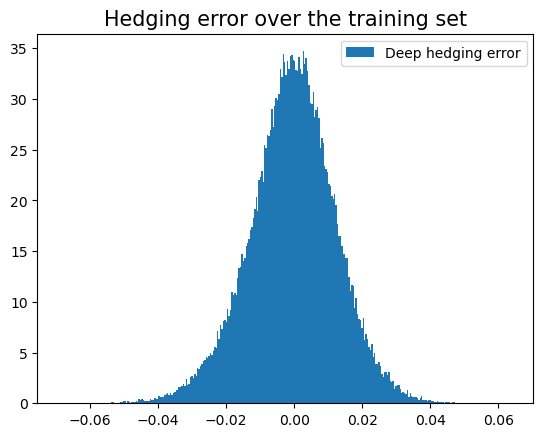

Deep hedging error sample average: -5.251e-04
Deep hedging error standard deviation: 1.279e-02 
 
Average option premium over the training set: 0.1043
Compare with the true Black-Scholes price : 0.0797 



In [13]:
# Hedging error = the first variable in the model output
hedging_error = model_output[:, 0]

plt.hist(hedging_error, bins=int(np.sqrt(N_train)), density="True", label="Deep hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("Deep hedging error sample average: %1.3e" %np.mean(hedging_error))
print("Deep hedging error standard deviation: %1.3e \n " %np.std(hedging_error))

# Option price we obtained from the training = the last variable in the model output
output_option_premium = model_output[:, -1]

print("Average option premium over the training set: %1.4f" %np.mean(output_option_premium))
print("Compare with the true Black-Scholes price : %1.4f \n" %priceBS)

How does the result look like?

Results are very satisfactory since we have obtained a very good approximation of the Black-Scholes theoritical price. The deep hedging error is also very small.

$\blacktriangleright$ __Now compare__ the hedging error of the deep model with the one of the theoretical Black-Scholes strategy (with the good value of $\sigma$), over the training set.

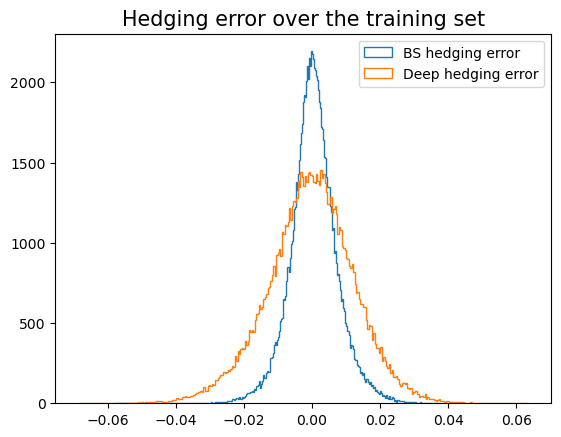

BS hedging error sample average: 4.149e-04
BS hedging error standard deviation: 6.993e-03 
 
Deep hedging error sample average: -5.251e-04
Dep hedging error standard deviation: 1.279e-02 
 


In [14]:
hedge = np.zeros(N_train)
price = S0 * np.ones((N_train, N))

# We implement the simulation of the BS hedging strategy
for k in range(N-1):
    # We use the log-increments from the training set
    price[:, k+1] = price[:,k] * np.exp(log_increments[k][:,].T) # COMPLETE HERE: we build all the N_train asset price trajectories

    # The theoretical Black-Scholes delta over the trajectories in the train set, at the current time
    tau = T - grid[k] # T - t_k
    d_1 = (np.log(price[:, k]/strike) / (sigma*np.sqrt(tau)) + 0.5*sigma*np.sqrt(tau))
    BS_delta_train = sps.norm.cdf(d_1)

    # The evolution of the hedging portfolio with the BS delta
    hedge = hedge + BS_delta_train * (price[:, k+1] - price[:, k])

hedging_error_BS = priceBS + hedge - np.maximum(price[:,-1] - strike, 0)

plt.hist(hedging_error_BS, bins=int(np.sqrt(N_train)), histtype='step', label="BS hedging error")

# We plot the hedging error of the deep model again, for comparison with BS
plt.hist(hedging_error, bins=int(np.sqrt(N_train)), histtype='step', label="Deep hedging error")

plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("BS hedging error sample average: %1.3e" %np.mean(hedging_error_BS))
print("BS hedging error standard deviation: %1.3e \n " %np.std(hedging_error_BS))

print("Deep hedging error sample average: %1.3e" %np.mean(hedging_error))
print("Dep hedging error standard deviation: %1.3e \n " %np.std(hedging_error))

$\blacktriangleright$ Is the error better? How much better with respect to the one of the deep hedging model?

The error of the Deep Hedging model is twice as large as the Black-sScholes on average, with an higher standard deviation.

__After the training__: in the cell below, we define a test set.

In [31]:
N_test = 10000

# points over which the deep model outputs the hedging strategy
hedge_eval_grid = S0 * np.linspace(0.5, 1.5, N_test).reshape(N_test, 1) # change this if you go to higher dimension m

log_increments_test = [ np.zeros((N_test, m)) for i in range(N) ]

xtest = ([S0 * np.ones((N_test, m))]
          + [np.zeros((N_test, m))]  # initial values for the delta hedging part
          + [ hedge_eval_grid ]
          + [np.zeros((N_test, m))] # input values for the option premium
          + log_increments_test)

$\blacktriangleright$ __Compare__ the model delta hedge (that is, the hedging strategy predicted by the deep model) with the theoretical Black-Scholes hedging strategy $\delta(t,S_t) = N(d_1(t,S_t))$ where $d_1(t,S_t) = \frac{\log \frac{S_t}K}{\sigma \sqrt{T-t}} + \frac 12 \sigma \sqrt{T-t}$, over the grid of points in the test set.

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


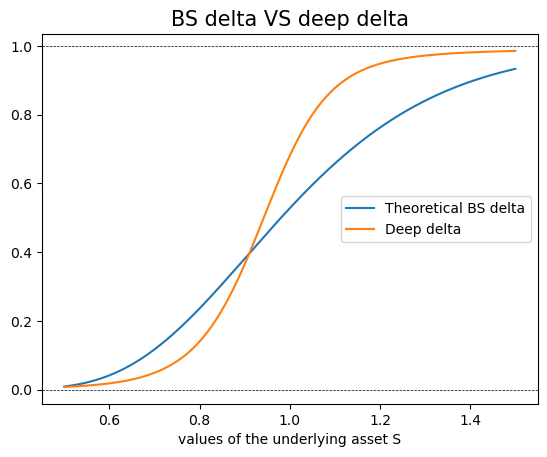

In [38]:
# Let us choose a point on the grid of N time points t_j

l = 50

# Remaining time to maturity
tau = T - grid[l]

# The true theoretical Black-Scholes delta of the call option
d1 = np.log(hedge_eval_grid / strike) / sigma*np.sqrt(tau) + 0.5*sigma*np.sqrt(tau)
BS_delta = sps.norm.cdf(d1)

# The deep model delta
model_delta = model_hedge_strat.predict(xtest)[:, l-1]

plt.plot(hedge_eval_grid, BS_delta, label="Theoretical BS delta")
plt.plot(hedge_eval_grid, model_delta, label="Deep delta")

plt.axhline(0, linestyle="--", linewidth=0.5, color="k")
plt.axhline(1, linestyle="--", linewidth=0.5, color="k")

plt.xlabel("values of the underlying asset S")
plt.title("BS delta VS deep delta", fontsize=15)
plt.legend(loc="best")
plt.show()

## To Do's

1. With a train set of $10^4$ trajectories (and the number of epochs above), the performance of the model is not really satisfactory.
Rerun the model training over a set of $N_{train} = 10^5$ asset paths.

3. The current notebook is written for interest rate $r=0$. Take into account a non-zero interest rate (say, $r=0.05$) in the evolution of the hedging portfolio.

4. Define a test set of $N_{test} = 10^4$ (or more) new trajectories and compare the performances of the deep model with the ones of the Black-Scholes delta-hedging strategy over the test set, in terms of distribution of the hedging error (when $r\neq 0$).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

__To go further__. Deep Hedging goes back to the following [paper](https://arxiv.org/abs/1802.03042) by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood.

The present notebook is inspired by the course on [Machine Learning in Finance](https://people.math.ethz.ch/~jteichma/index.php?content=teach_mlf2023) by Josef Teichmann at ETH Zurich. The course by J. Teichmann and the article above require knowledge of Ito calculus (stochastic integration with respect to the Brownian motion), while the current notebook does not (but the deep hedging problem we consider remains the same).